# Averaged data

In [1]:
from pandas import HDFStore, DataFrame, Series
from tqdm.auto import tqdm
from pandas import concat


def load_averaged_data(path: str) -> tuple[DataFrame, Series, Series]:
    loaded_data: dict[str, DataFrame] = {}

    # Open the HDF5 file
    with HDFStore(path) as store:
        # Iterate through the keys (group names) in the HDF5 file
        for key in tqdm(store.keys(), desc='Loading data'):
            # Load each DataFrame and store it in the dictionary
            loaded_data[key] = store[key]

    concated_df_avgs = concat(
        [loaded_data[key][("Average", "Balanced Accuracy")] for key in loaded_data.keys()],
        axis=1,
        keys=[el[1:] for el in loaded_data.keys()],
    )
    concated_df_errs = concat(
        [loaded_data[key][("Standard error", "Balanced Accuracy")] for key in loaded_data.keys()],
        axis=1,
        keys=[el[1:] for el in loaded_data.keys()],
    )
    df_avgs = concated_df_avgs.unstack().reset_index()
    df_avgs.columns = ["side", "classifier", "balanced accuracy"]

    df_errs = concated_df_errs.unstack().reset_index()
    df_errs.columns = ["side", "classifier", "balanced accuracy"]
    upper_errs = df_errs["balanced accuracy"]
    lower_errs = df_errs["balanced accuracy"]
    return df_avgs, upper_errs, lower_errs, df_errs
    
def make_linerrorplot(data: DataFrame, lower_errs: Series, upper_errs: Series, path_to_save: str) -> None:
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    
    plt.figure(figsize=(3, 7))
    sns.set_style("darkgrid")
    
    palette = sns.color_palette("colorblind")
    # sns.scatterplot(data=df, x='side', y='accuracy', hue='classifier')
    plt.errorbar(
        x=data["side"],
        y=data["balanced accuracy"],
        xerr=None,
        yerr=(lower_errs, upper_errs),
        # label=custom_label,
        elinewidth=5,
        linestyle="none",
        markersize=1,
        marker=".",
        color=palette[0],
        ecolor=(*palette[0], 0.3),
    )
    plt.ylim(0.5, 1.0)
    
    plt.savefig(path_to_save, bbox_inches="tight")
    plt.show()
    # legend off
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    # 

## USILaughs

In [2]:
path_to_save_data_avgs = "../data.nosync/usilaughs/results/loso_nested_avg.h5"
# Create an empty dictionary to store the loaded DataFrames
df_avgs, upper_errs, lower_errs, df_errs = load_averaged_data(path_to_save_data_avgs)

Loading data:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
print(df_avgs['classifier'].nunique())
print(df_avgs['classifier'].unique())

26
['RandomForestClassifier' 'AdaBoostClassifier' 'ExtraTreesClassifier'
 'LGBMClassifier' 'XGBClassifier' 'BernoulliNB' 'BaggingClassifier'
 'LinearDiscriminantAnalysis' 'LogisticRegression' 'LinearSVC'
 'RidgeClassifier' 'RidgeClassifierCV' 'DecisionTreeClassifier'
 'SGDClassifier' 'PassiveAggressiveClassifier' 'KNeighborsClassifier'
 'NearestCentroid' 'SVC' 'QuadraticDiscriminantAnalysis' 'GaussianNB'
 'ExtraTreeClassifier' 'LabelSpreading' 'LabelPropagation' 'NuSVC'
 'Perceptron' 'DummyClassifier']


In [4]:
maxes = (
    concat([df_errs["balanced accuracy"], df_avgs], axis=1, keys=["errors", "averages"])
    .groupby(("averages", "side"))
    .max()
)
display(maxes * 100)


errors  \
                 balanced accuracy   
(averages, side)                     
left                      0.468352   
lxrx                      2.054321   
right                     0.486386   
rxlx                      2.817903   

                                                           averages  \
                                                         classifier   
(averages, side)                                                      
left              XGBClassifierXGBClassifierXGBClassifierXGBClas...   
lxrx              XGBClassifierXGBClassifierXGBClassifierXGBClas...   
right             XGBClassifierXGBClassifierXGBClassifierXGBClas...   
rxlx              XGBClassifierXGBClassifierXGBClassifierXGBClas...   

                                    
                 balanced accuracy  
(averages, side)                    
left                     63.958444  
lxrx                     75.382667  
right                    75.438889  
rxlx                     68.471111

## MWC2022

In [5]:
path_to_save_data_avgs = "../data.nosync/mwc2022/results/loso_avg.h5"
# Create an empty dictionary to store the loaded DataFrames
df_avgs, upper_errs, lower_errs, df_errs = load_averaged_data(path_to_save_data_avgs)

Loading data:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
display(
    concat([df_errs["balanced accuracy"], df_avgs], axis=1, keys=["errors", "averages"])
    .groupby(("averages", "side"))
    .max()*100
)


errors                                           averages  \
                  accuracy                                         classifier   
(averages, side)                                                                
left              0.449500  XGBClassifierXGBClassifierXGBClassifierXGBClas...   
lxrx              0.425577  XGBClassifierXGBClassifierXGBClassifierXGBClas...   
right             0.403300  XGBClassifierXGBClassifierXGBClassifierXGBClas...   
rxlx              0.464573  XGBClassifierXGBClassifierXGBClassifierXGBClas...   

                             
                   accuracy  
(averages, side)             
left              77.762699  
lxrx              74.821950  
right             73.104632  
rxlx              78.062530

# Total data

In [2]:
from pandas import DataFrame, concat, MultiIndex, Series
from collections import defaultdict
from pandas import concat
from numpy import nanstd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import itertools
from pandas import HDFStore, DataFrame
from tqdm.auto import tqdm
from scipy.stats import shapiro, anderson, ttest_ind


def calculate_fold_df(data: DataFrame, n_folds: int) -> DataFrame:
    avgs = concat(
        [fold_res["Balanced Accuracy"] for fold_res in data.values()],
        axis=1,
        keys=range(5),
    ).mean(axis=1)
    errs = concat(
        [fold_res["Balanced Accuracy"] for fold_res in data.values()],
        axis=1,
        keys=range(n_folds),
    ).apply(lambda x: nanstd(x) / ((len(x - 1)) ** 0.5) if len(x) > 1 else 1, axis=1)
    stds = concat(
        [fold_res["Balanced Accuracy"] for fold_res in data.values()],
        axis=1,
        keys=range(n_folds),
    ).apply(lambda x: nanstd(x), axis=1)
    return concat(
        [avgs, errs, stds],
        axis=1,
        keys=["Balanced Accuracy", "Standard Error", "Standard Deviation"],
    )


def concatenate_prepared_data(data: dict[str, DataFrame]) -> DataFrame:
    concated_df_dict: dict[DataFrame, Series] = {}
    sides: list[str] = ["left", "right", "lxrx", "rxlx"]
    for side in sides:
        concated_df_dict[side] = concat(
            [
                data[key][
                    ["Balanced Accuracy", "Standard Error", "Standard Deviation"]
                ].sort_index()
                for key in data.keys()
                if side in key
            ],
            axis=0,
            keys=[key[1:5] for key in data.keys() if side in key],
        )
        concated_df_dict[side].index = concated_df_dict[side].index.droplevel(0)

    all_results = concat(
        list(concated_df_dict.values()),
        axis=0,
        keys=sides,
        # ignore_index=True,
    )
    all_results = all_results.reset_index()
    all_results.columns = [
        "Side",
        "Model",
        "Balanced Accuracy",
        "Standard Error",
        "Standard Deviation",
    ]
    return all_results


def load_prepare_data(path_to_all_data: str, n_folds: int) -> DataFrame:
    loaded_data = defaultdict(lambda: defaultdict(lambda: dict()))

    # Open the HDF5 file
    with HDFStore(path_to_all_data) as store:
        # Iterate through the keys (group names) in the HDF5 file
        for key in tqdm(store.keys(), desc="Loading data"):
            # Load each DataFrame and store it in the dictionary
            data = store[key]
            split_key = key.split("_")
            loaded_data[split_key[0]][split_key[1]][split_key[2]] = data

    loaded_data_correct = {
        f"{key1}_{key2}": calculate_fold_df(loaded_data[key1][key2], n_folds=n_folds)
        for key1 in loaded_data.keys()
        for key2 in loaded_data[key1].keys()
    }

    return concatenate_prepared_data(data=loaded_data_correct)


def remove_dummy(data: DataFrame) -> DataFrame:
    return data[data["Model"] != "DummyClassifier"]


def make_violin_accuracy(
    data: DataFrame,
    sides: list[str],
    path_to_save_fig: str,
    small_fontsize: int = 14,
    medium_fontsize: int = 18,
    large_fontsize: int = 20,
    xlim: tuple[float, float] | None = None,
):
    # set seaborn style
    sns.set_style("darkgrid")

    # # set latex font
    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"
    # plt.rcParams.update({"font.size": figsize *8})
    plt.rcParams["axes.grid"] = True

    # increase font size
    plt.rc("font", size=small_fontsize)  # controls default text sizes
    plt.rc("axes", titlesize=medium_fontsize)  # fontsize of the axes title
    plt.rc("axes", labelsize=large_fontsize)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=small_fontsize)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=small_fontsize)  # fontsize of the tick labels
    plt.rc("legend", fontsize=medium_fontsize)  # legend fontsize
    plt.rc("figure", titlesize=large_fontsize)  # fontsize of the figure title
    plt.rcParams.update({"font.size": medium_fontsize})

    ax = sns.violinplot(
        data=data,
        y="Train-Test",
        x="Balanced Accuracy",
        palette="colorblind",
        orient="h",
    )
    # annotator = Annotator(
    #     ax,
    #     list(itertools.combinations(sides, 2)),
    #     data=data,
    #     x="Balanced Accuracy",
    #     y="Train-Test",
    #     orient="h",
    #     order=sides,
    # )
    # annotator.configure(test="Wilcoxon", 
    #                     comparisons_correction="HB",
    #                     text_format="star", loc="outside")
    # annotator.apply_and_annotate()

    # set vertical line at 0.5
    plt.axvline(x=0.5, color="black", linestyle="--", linewidth=1)
    if xlim:
        plt.xlim(xlim)
    plt.savefig(path_to_save_fig, bbox_inches="tight")
    plt.show()


def clean_side_names(
    data: DataFrame, renaming_dict: dict[str, str] | None = None
) -> DataFrame:
    if renaming_dict is None:
        renaming_dict = {
            "left": "Left-Left",
            "right": "Right-Right",
            "lxrx": "Left-Right",
            "rxlx": "Right-Left",
        }
    renaming_dict: dict[str, str]
    data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)
    return data.rename(columns={"Side": "Train-Test"}, inplace=False)


def test_normality(all_xgb_results: dict) -> None:
    # test the normality of all three data distributions
    for side, data in all_xgb_results.items():
        print(f"Shapiro-Wilk test for normality on data set {side}:")
        print(shapiro(data["Balanced Accuracy"]))
        # make the histogram with kernel of the data distribution
        sns.distplot(
            data["Balanced Accuracy"],
            hist=True,
            kde=True,
            color="darkblue",
            hist_kws={"edgecolor": "black"},
            kde_kws={"linewidth": 4},
        )
        plt.show()
        print(f"Anderson-Darling test for normality on data set {side}:")
        print(anderson(data["Balanced Accuracy"]))


def simple_t_test(
    side_combinations: list[str], all_xgb_results: dict[str, DataFrame]
) -> dict[str, tuple]:
    t_test_results = {}
    for combination in side_combinations:
        el1 = all_xgb_results[combination[0]]["Balanced Accuracy"]
        el2 = all_xgb_results[combination[1]]["Balanced Accuracy"]
        t, p = ttest_ind(el1, el2)
        t_test_results[combination] = (t, p, p > 0.05)
    return t_test_results


## USILaughs

In [3]:
path_to_save_data_avgs = "../data.nosync/usilaughs/results/loso_nested_all.h5"

order = [
    "Left-Left",
    "Right-Right",
    "Left-Right",
    "Right-Left",
]
# Create an empty dictionary to store the loaded DataFrames
all_results = load_prepare_data(path_to_save_data_avgs, n_folds=32)
all_results_no_dummy = remove_dummy(data=all_results)
all_results_no_dummy = clean_side_names(data=all_results_no_dummy)


Loading data:   0%|          | 0/15000 [00:00<?, ?it/s]

/tmp/ipykernel_435277/705851056.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)


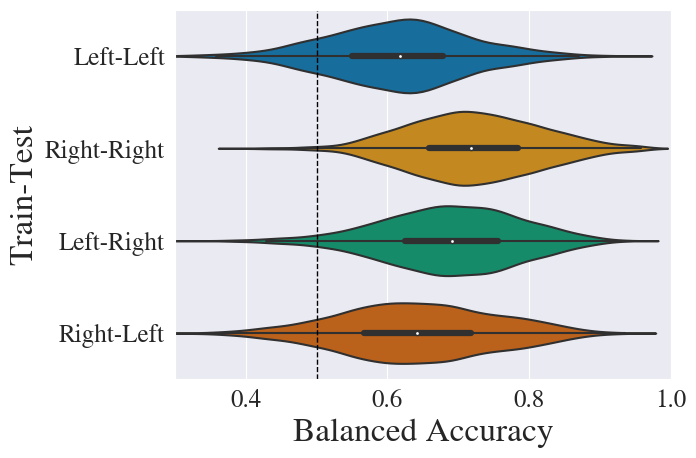

In [4]:
make_violin_accuracy(
    data=all_results_no_dummy,
    sides=order,
    path_to_save_fig="../final_visualizations/violin_loso_accuracy_usilaughs.pdf",
    xlim=(0.3,1),
    small_fontsize=18, 
    medium_fontsize=24,
    large_fontsize=25,
)


In [22]:
average_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].mean()
# NOTE: this error estimation is not actually correct.
err_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].std() / (all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].count().apply(lambda x: x**0.5))
for i in range(len(average_acc)):
    # print accuracy with format '0.2f' (2 decimal places)
    print('Average accuracy for {} side: {:.2f} ± {:.2f}'.format(average_acc.index[i], average_acc[i]*100, err_acc[i]*100))

Average accuracy for Left-Left side: 61.56 ± 0.18
Average accuracy for Left-Right side: 68.83 ± 0.17
Average accuracy for Right-Left side: 64.22 ± 0.20
Average accuracy for Right-Right side: 72.19 ± 0.17


In [23]:
max_acc = all_results_no_dummy.groupby('Train-Test').max()
display(max_acc)

,Model,Balanced Accuracy,Standard Error,Standard Deviation
Train-Test,,,,
Left-Left,XGBClassifier,0.933333,0.062770,0.343805
Left-Right,XGBClassifier,0.943333,0.054064,0.296123
Right-Left,XGBClassifier,0.935000,0.064910,0.355525
Right-Right,XGBClassifier,0.958333,0.056214,0.307896


### Statistical Tests

In [9]:
side_testing = all_results_no_dummy["Train-Test"].unique().tolist()

all_xgb_results = {
    train_test_paradigm: all_results_no_dummy[
        (all_results_no_dummy["Train-Test"] == train_test_paradigm)
        & (all_results_no_dummy["Model"] == "XGBClassifier")
    ]
    for train_test_paradigm in side_testing
}

# get all possible combinations for the side_testing list

side_combinations = list(itertools.combinations(side_testing, 2))

Shapiro-Wilk test for normality on data set Left-Left:
ShapiroResult(statistic=0.8840371370315552, pvalue=2.7003574132322683e-07)


/home/leonardo/miniforge3/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


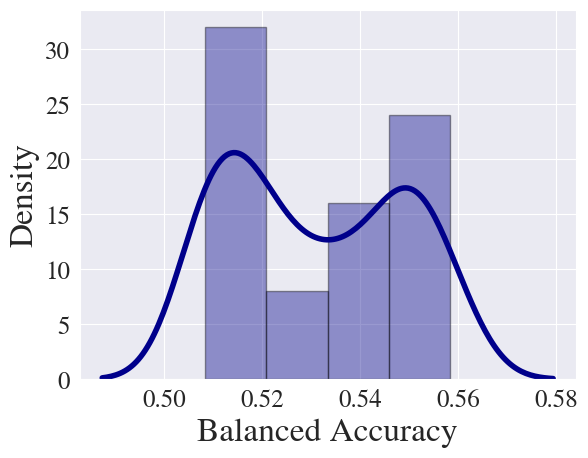

Anderson-Darling test for normality on data set Left-Left:
AndersonResult(statistic=3.9684565693675893, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.5308333333333333, scale=0.017588161767036245)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set Right-Right:
ShapiroResult(statistic=0.8452641367912292, pvalue=7.957838832339803e-09)


/home/leonardo/miniforge3/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


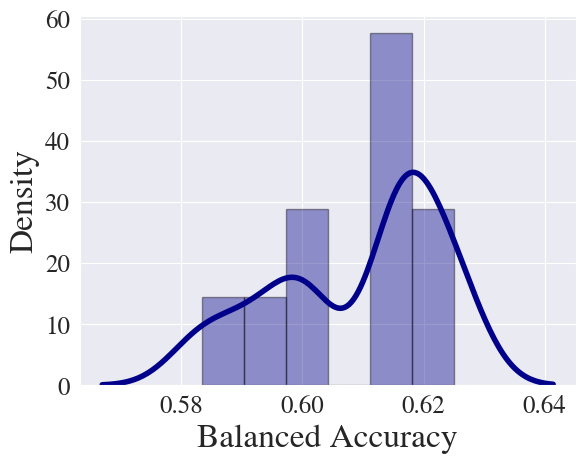

Anderson-Darling test for normality on data set Right-Right:
AndersonResult(statistic=6.501586214367563, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.6091666666666665, scale=0.013736538150463775)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set Left-Right:
ShapiroResult(statistic=0.8772855401039124, pvalue=1.3955074962268554e-07)


/home/leonardo/miniforge3/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


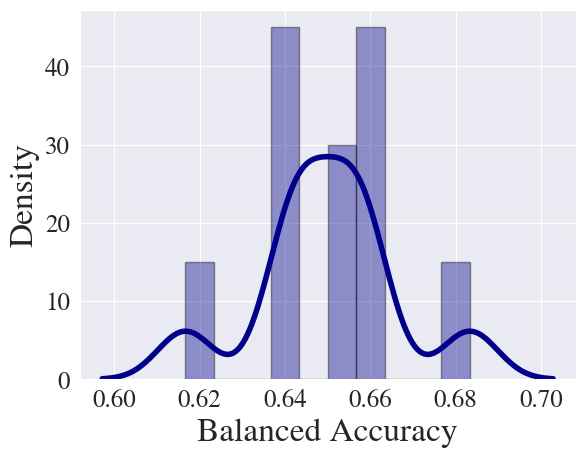

Anderson-Darling test for normality on data set Left-Right:
AndersonResult(statistic=4.647715433172976, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.6499999999999999, scale=0.01632649482347942)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set Right-Left:
ShapiroResult(statistic=0.8817718625068665, pvalue=2.1585249498912162e-07)


/home/leonardo/miniforge3/envs/laugh/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


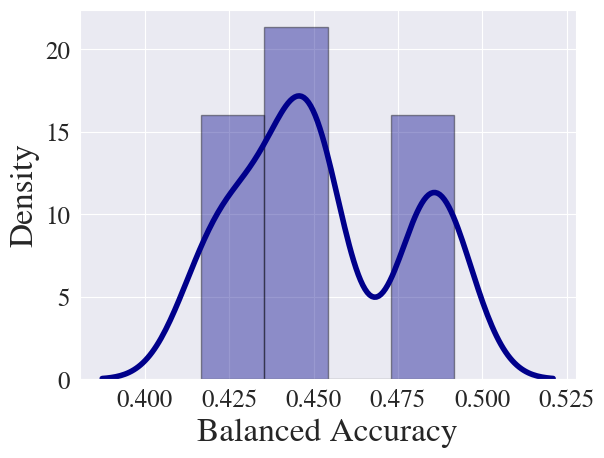

Anderson-Darling test for normality on data set Right-Left:
AndersonResult(statistic=4.647631994175214, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.4524999999999999, scale=0.024575520929498686)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [11]:
test_normality(all_xgb_results=all_xgb_results)

Statistical tests say that the distributions are not normal. But upon visual inspection, they are not far from a normal. As such, the t-test should be able handle this data, since with n>30 it is still robust to non-normality.

In [12]:
t_test_results = simple_t_test(all_xgb_results=all_xgb_results, side_combinations=side_combinations)

This t test evaluated the mean and standard deviation directly. However, a stronger approach would be to use the calculate standard deviation. I perform this in the average part.

In [13]:
t_test_results

{('Left-Left', 'Right-Right'): (-35.1007403316651,
  5.953808737838908e-87,
  False),
 ('Left-Left', 'Left-Right'): (-49.65718041111932,
  1.0334191668805604e-113,
  False),
 ('Left-Left', 'Right-Left'): (25.920296123927177,
  1.4886316100150367e-65,
  False),
 ('Right-Right', 'Left-Right'): (-19.13776991418113,
  6.600620731536683e-47,
  False),
 ('Right-Right', 'Right-Left'): (55.646291291633055,
  7.497986729474644e-123,
  False),
 ('Left-Right', 'Right-Left'): (66.93912830074184,
  6.144150105716988e-138,
  False)}

In [14]:
all_xgb_results['Left-Left']

,Train-Test,Model,Balanced Accuracy,Standard Error,Standard Deviation
26,Left-Left,XGBClassifier,0.516667,0.035777,0.202385
53,Left-Left,XGBClassifier,0.550000,0.038953,0.220352
80,Left-Left,XGBClassifier,0.550000,0.038953,0.220352
107,Left-Left,XGBClassifier,0.550000,0.038953,0.220352
134,Left-Left,XGBClassifier,0.550000,0.038953,0.220352
...,...,...,...,...,...
2591,Left-Left,XGBClassifier,0.541667,0.038096,0.215502
2618,Left-Left,XGBClassifier,0.541667,0.038096,0.215502
2645,Left-Left,XGBClassifier,0.541667,0.038096,0.215502
2672,Left-Left,XGBClassifier,0.541667,0.038096,0.215502


In [15]:
all_xgb_results[side_combinations[0][0]]
all_xgb_results[side_combinations[0][1]]

,Train-Test,Model,Balanced Accuracy,Standard Error,Standard Deviation
2726,Right-Right,XGBClassifier,0.616667,0.034936,0.197625
2753,Right-Right,XGBClassifier,0.616667,0.035789,0.202452
2780,Right-Right,XGBClassifier,0.616667,0.035789,0.202452
2807,Right-Right,XGBClassifier,0.616667,0.035789,0.202452
2834,Right-Right,XGBClassifier,0.616667,0.035789,0.202452
...,...,...,...,...,...
5291,Right-Right,XGBClassifier,0.583333,0.038601,0.218362
5318,Right-Right,XGBClassifier,0.583333,0.038601,0.218362
5345,Right-Right,XGBClassifier,0.583333,0.038601,0.218362
5372,Right-Right,XGBClassifier,0.583333,0.038601,0.218362


In [ ]:
from scipy.stats import ttest_ind_from_stats

ttest_ind_from_stats(mean1=..., std1=..., nobs1=..., )

## MWC2022

In [5]:
path_to_save_data_avgs = "../data.nosync/mwc2022/results/loso_nested_all.h5"

order = [
    "Left-Left",
    "Right-Right",
    "Left-Right",
    "Right-Left",
]
# Create an empty dictionary to store the loaded DataFrames
all_results = load_prepare_data(path_to_save_data_avgs, n_folds=7)
all_results_no_dummy = remove_dummy(data=all_results)
all_results_no_dummy = clean_side_names(data=all_results_no_dummy)


Loading data:   0%|          | 0/3500 [00:00<?, ?it/s]

/tmp/ipykernel_435277/705851056.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)


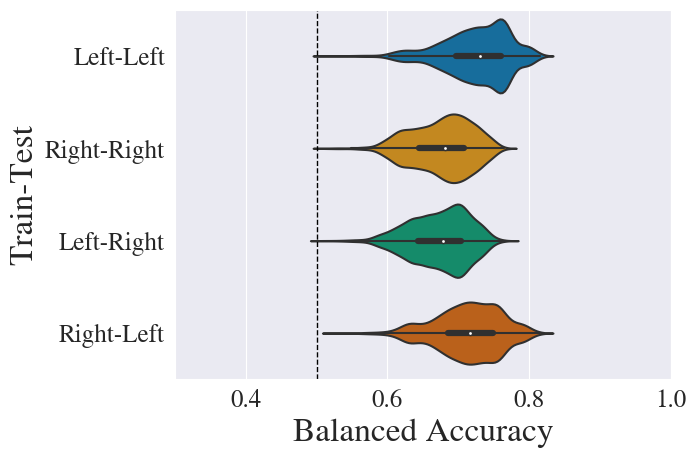

In [6]:
make_violin_accuracy(
    data=all_results_no_dummy,
    sides=order,
    path_to_save_fig="../final_visualizations/violin_loso_accuracy_mwc2022.pdf",
    xlim=(0.3,1),
    small_fontsize=18, 
    medium_fontsize=24,
    large_fontsize=25,
)


In [26]:
average_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].mean()
# NOTE: this error estimation is not actually correct.
err_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].std() / (all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].count().apply(lambda x: x**0.5))
for i in range(len(average_acc)):
    # print accuracy with format '0.2f' (2 decimal places)
    print('Average accuracy for {} side: {:.2f} ± {:.2f}'.format(average_acc.index[i], average_acc[i]*100, err_acc[i]*100))

Average accuracy for Left-Left side: 72.46 ± 0.08
Average accuracy for Left-Right side: 67.30 ± 0.07
Average accuracy for Right-Left side: 71.33 ± 0.08
Average accuracy for Right-Right side: 67.60 ± 0.08


In [27]:
max_acc = all_results_no_dummy.groupby('Train-Test').max()
display(max_acc)

,Model,Balanced Accuracy,Standard Error,Standard Deviation
Train-Test,,,,
Left-Left,XGBClassifier,0.814774,0.059980,0.158692
Left-Right,XGBClassifier,0.768009,0.053761,0.142238
Right-Left,XGBClassifier,0.815238,0.075613,0.200054
Right-Right,XGBClassifier,0.764769,0.068968,0.182472


### Statistical Tests

In [9]:
side_testing = all_results_no_dummy["Train-Test"].unique().tolist()

all_xgb_results = {
    train_test_paradigm: all_results_no_dummy[
        (all_results_no_dummy["Train-Test"] == train_test_paradigm)
        & (all_results_no_dummy["Model"] == "XGBClassifier")
    ]
    for train_test_paradigm in side_testing
}

# get all possible combinations for the side_testing list

side_combinations = list(itertools.combinations(side_testing, 2))

Shapiro-Wilk test for normality on data set Left-Left:
ShapiroResult(statistic=0.9053229689598083, pvalue=2.5380543320352444e-06)


/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


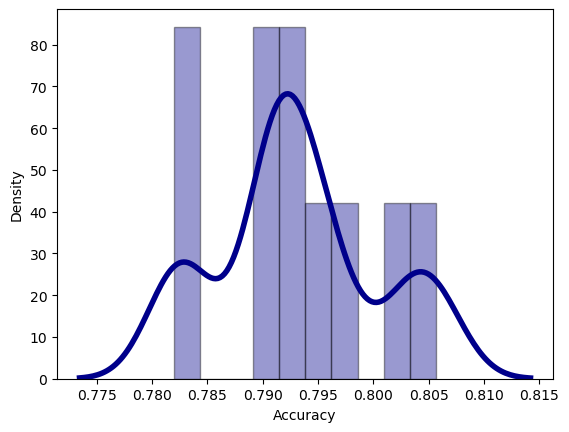

Anderson-Darling test for normality on data set Left-Left:
AndersonResult(statistic=3.4045955710857214, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.7930442891990039, scale=0.0071219168369116214)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set Right-Right:
ShapiroResult(statistic=0.8929948210716248, pvalue=6.719153589074267e-07)


/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


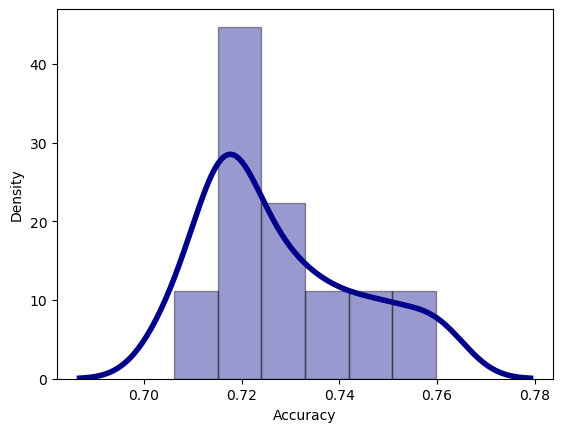

Anderson-Darling test for normality on data set Right-Right:
AndersonResult(statistic=3.8755524277630684, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.7279684291488009, scale=0.016154481087069832)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set Left-Right:
ShapiroResult(statistic=0.8976187705993652, pvalue=1.0943866755042109e-06)


/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


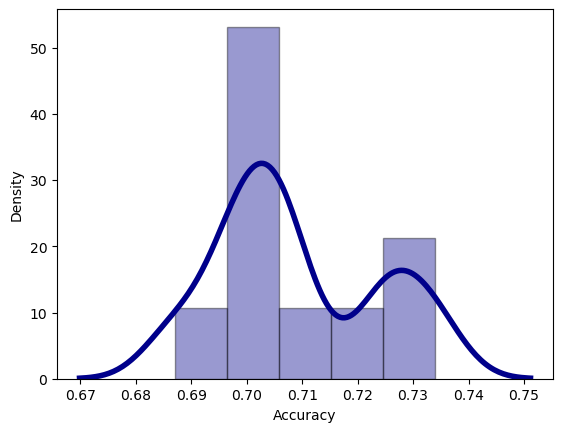

Anderson-Darling test for normality on data set Left-Right:
AndersonResult(statistic=4.058260593368857, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.7088539364696347, scale=0.01434672735654215)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk test for normality on data set Right-Left:
ShapiroResult(statistic=0.8613976240158081, pvalue=3.2022565932265934e-08)


/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


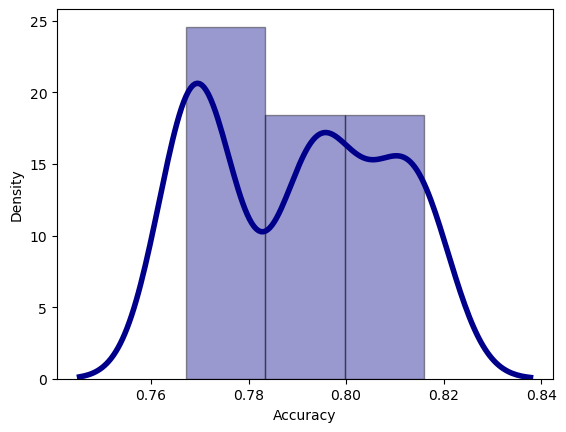

Anderson-Darling test for normality on data set Right-Left:
AndersonResult(statistic=4.799576566125083, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.7897832882179858, scale=0.018247523591483204)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [10]:
test_normality(all_xgb_results=all_xgb_results)

Statistical tests say that the distributions are not normal. But upon visual inspection, they are not far from a normal. As such, the t-test should be able handle this data, since with n>30 it is still robust to non-normality.

In [11]:
t_test_results = simple_t_test(all_xgb_results=all_xgb_results, side_combinations=side_combinations)

This t test evaluated the mean and standard deviation directly. However, a stronger approach would be to use the calculate standard deviation. I perform this in the average part.

In [12]:
t_test_results

{('Left-Left', 'Right-Right'): (36.860329025154776,
  1.331362607448869e-90,
  False),
 ('Left-Left', 'Left-Right'): (52.56250786374819,
  2.937912170655338e-118,
  False),
 ('Left-Left', 'Right-Left'): (1.6647864377671946, 0.09753695982777054, True),
 ('Right-Right', 'Left-Right'): (8.847066362673754,
  5.004031386477295e-16,
  False),
 ('Right-Right', 'Right-Left'): (-25.36423826062485,
  4.055981213206209e-64,
  False),
 ('Left-Right', 'Right-Left'): (-34.86518586804938,
  1.8774720980255272e-86,
  False)}